In [1]:
%load_ext autoreload
%autoreload 2

import text3d2video.wandb_util as wu
from text3d2video.artifacts.vertex_atributes_artifact import VertAttributesArtifact

In [111]:
features_3d_artifact_tag = 'deadpool-3d-features:latest'

# get 3d features
features_3d = wu.get_artifact(features_3d_artifact_tag)
features_3d = VertAttributesArtifact.from_wandb_artifact(features_3d)

aggr_run = features_3d.logged_by()
mv_features = features_3d.get_mv_features_from_lineage()
animation = features_3d.get_animation_from_lineage()
vert_features = features_3d.get_vert_features().cuda()

# extract feature config
feature_timestep = aggr_run.config['feature_timestep']
level = aggr_run.config['feature_layer']
feature_identifier = {'layer': level, 'timestep': feature_timestep}
feature_resolution = mv_features.get_resolution(feature_identifier)

wandb:   1 of 1 files downloaded.  
wandb: Downloading large artifact deadpool-mv-features:v4, 3446.13MB. 82 files... 
wandb:   82 of 82 files downloaded.  
Done. 0:0:1.0
wandb: Downloading large artifact deadpool-mv-features:v4, 3446.13MB. 82 files... 
wandb:   82 of 82 files downloaded.  
Done. 0:0:1.0
wandb: Downloading large artifact backflip:v0, 121.09MB. 61 files... 
wandb:   61 of 61 files downloaded.  
Done. 0:0:0.4


/home/jorge/miniconda3/envs/thesis/lib/python3.8/site-packages/pytorch3d/io/obj_io.py:546: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


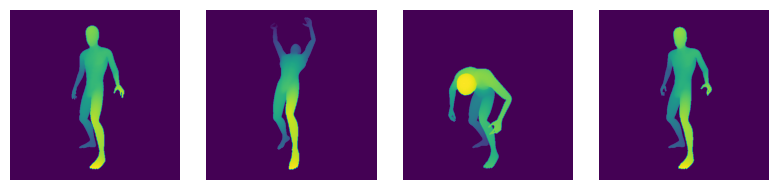

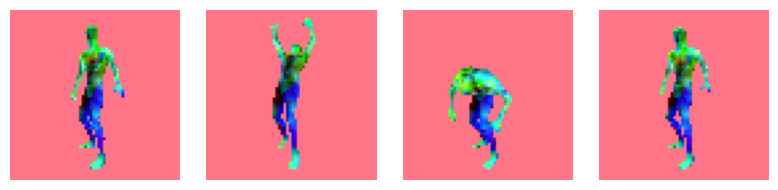

In [151]:
from einops import rearrange
from omegaconf import OmegaConf
from text3d2video.ipython_utils import display_ims
from text3d2video.rendering import make_rasterizer, normalize_depth_map, rasterize_vertex_features
from text3d2video.util import front_camera, ordered_sample
from text3d2video.visualization import RgbPcaUtil
import matplotlib.pyplot as plt
import torch
import torchvision.transforms.functional as TF

cfg = OmegaConf.create({})
cfg.seed = 0
cfg.batch_size = 4
cfg.prompt = 'Deadpool'
cfg.frame_indices = ordered_sample(animation.frame_nums(), cfg.batch_size)
cfg.out_resolution = 512

camera = front_camera()

frames = animation.load_frames(cfg.frame_indices)

rasterizer = make_rasterizer(camera, cfg.out_resolution)
fragments = rasterizer(frames)
depth_maps = normalize_depth_map(fragments.zbuf)
depth_maps  = [TF.to_pil_image(depth_map[:, :, 0]) for depth_map in depth_maps]

display_ims(depth_maps, scale=2)

rendered_features = torch.stack([
    rasterize_vertex_features(camera, frame, feature_resolution, vert_features)
    for frame in frames
])

all_features = rearrange(rendered_features, 'b c h w -> (b h w) c')
pca = RgbPcaUtil(all_features.shape[1])
pca.fit(all_features.cpu())
pca_maps = [pca.feature_map_to_rgb_pil(map.cpu()) for map in rendered_features]

display_ims(pca_maps, scale=2)

In [152]:
from diffusers import ControlNetModel, DDIMScheduler

from text3d2video.pipelines.pipeline_3df import StableDiffusion3D2Video

controlnet_repo = "lllyasviel/control_v11f1p_sd15_depth"
sd_repo = "runwayml/stable-diffusion-v1-5"
dtype = torch.float16

scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)

controlnet_depth = ControlNetModel.from_pretrained(controlnet_repo, torch_dtype=dtype)
pipe = StableDiffusion3D2Video.from_pretrained(sd_repo, controlnet=controlnet_depth, torch_dtype=dtype, scheduler=scheduler)

pipe.enable_model_cpu_offload(gpu_id=0)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]/home/jorge/miniconda3/envs/thesis/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  3.84it/s]
/home/jorge/miniconda3/envs/thesis/lib/python3.8/site-packages/diffusers/loaders/lora_pipeline.py:2251: FutureWarning: `LoraLoaderMixin` is deprecated and will be removed in version 1.0.0. LoraLoaderMixin is deprecated and this will be removed in a future version. Please use `StableDiffusionLoraLoaderMixin`, instead.
  deprecate("LoraLoaderMixin", "1.0.0", deprecation_message)


In [153]:
cfg.negative_prompt = 'ugly'
cfg.controlnet_conditioning_scale = 1.0
cfg.rho = 0.001
cfg.guidance_scale = 9.0
cfg.num_inference_steps = 25
device = 'cuda'

generator = torch.Generator(device=device).manual_seed(cfg.seed)
prompts = [cfg.prompt] * cfg.batch_size
neg_prompts = [cfg.negative_prompt] * cfg.batch_size

start_code = torch.randn([1, 4, 64, 64], generator=generator, device=device).to(dtype)
latents = start_code.repeat(cfg.batch_size, 1, 1, 1)

images = pipe(
    prompts,
    depth_maps,
    feature_maps = rendered_features,
    feature_timestep=feature_timestep,
    inject_features= True,
    latents=latents,
    num_inference_steps=cfg.num_inference_steps,
    generator=generator,
    negative_prompt=neg_prompts,
    controlnet_conditioning_scale=cfg.controlnet_conditioning_scale,
    guidance_scale = cfg.guidance_scale,
).images

 84%|████████▍ | 21/25 [00:05<00:00,  4.78it/s]

features black


100%|██████████| 25/25 [00:06<00:00,  4.15it/s]


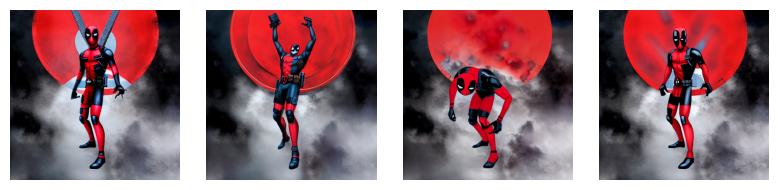

In [154]:
display_ims(images, scale=2)